#Resv Message 

- Each receiver will send RESV message upstream towards sender 
- PATH message and RESV follow exactly the same path 
- RESV responsible for creating and maintaining a reservation state along the way 
- RESV are sent periodically to refresh 
- Exactly same timer as Path - [(km + 0.5)*1.5*refresh-time]



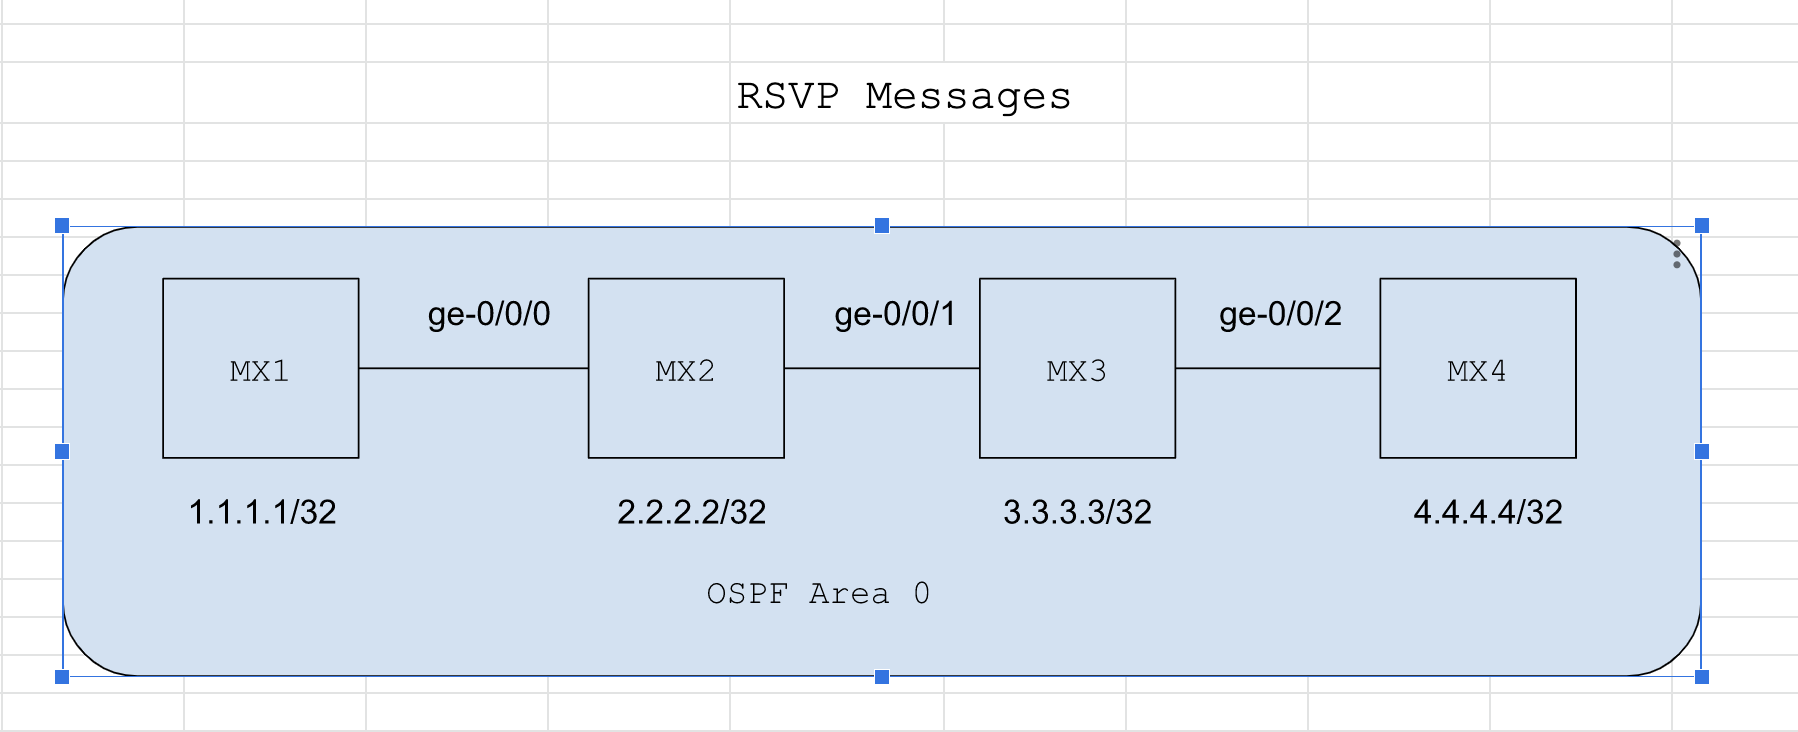

In [1]:
# Start all docker containers 
import os
import time 
list_of_containers = ['vmx1','vmx2','vmx3','vmx4','vr-xcon']
start_container = [os.system(f'sudo docker start {device}') for device in list_of_containers]

#lets allow container to start, approximately 60seconds-120seconds 
time.sleep(120)
print('Sleeping for 120 Seconds')

vmx1
vmx2
vmx3
vmx4
vr-xcon
Sleeping for 120 Seconds


In [2]:
# Script to initiate packet-captures on Juniper Routers 

from jnpr.junos import Device
from jnpr.junos.utils.start_shell import StartShell
from concurrent.futures import ThreadPoolExecutor
import time 

generated_file_list = [] #this is used to capture all the files generate for auto-fetching 
current_time = time.ctime().split()[3]

def initiate_pktcap(device_intf_tuple): #we have to use tuple here as multi-threading output is tuple 
    host = device_intf_tuple[0]
    interface = device_intf_tuple[1]
    try:
        dev = Device(host=host, user='lab',password='lab123').open()
    except:
        print('Exception in Connnecting')
    with StartShell(dev) as ss:
        interface_renamed = 'ge_'+''.join(interface[3:].split('/'))
        command_string = f'cli -c "monitor traffic interface {interface} write-file /var/tmp/{host}_{interface_renamed}_{current_time}.pcap extensive layer2-headers no-resolve"'
        print(command_string)
        generated_file_list.append(f'{host}_{interface_renamed}_{current_time}.pcap')
        ss.run(command_string,this=None,timeout=20)

In [3]:
# At this step, Manually initiate LSP's or clear one of the LSP's to re-trigger flow and RSVP LSP setup


In [4]:
device_interface_mapping = {'vmx1':['ge-0/0/0'], 'vmx2':['ge-0/0/0', 'ge-0/0/1'], 'vmx3':['ge-0/0/1','ge-0/0/2'],
                           'vmx4':['ge-0/0/2']}

#https://learn.acloud.guru/course/list-comprehension-in-python/learn/3baa87dd-d4f6-42a1-9a5d-f29052395e34/28bda287-a243-47f5-b259-0836e677b168/watch
#https://superfastpython.com/threadpoolexecutor-map-vs-submit/#:~:text=Products-,map()%20vs.,With%20the%20ThreadPoolExecutor%20in%20Python&text=Use%20map()%20when%20converting,using%20the%20ThreadPoolExecutor%20in%20Python.

print([(device,interface) for device,interfaces in device_interface_mapping.items() for interface in interfaces])
with ThreadPoolExecutor(max_workers=50) as e:
    e.map(initiate_pktcap, [(device,interface) for device,interfaces in device_interface_mapping.items() for interface in interfaces])
print(generated_file_list)


#ge-0/0/0 in naming wont work, so this has to be split into g0/0/0

    

[('vmx1', 'ge-0/0/0'), ('vmx2', 'ge-0/0/0'), ('vmx2', 'ge-0/0/1'), ('vmx3', 'ge-0/0/1'), ('vmx3', 'ge-0/0/2'), ('vmx4', 'ge-0/0/2')]
cli -c "monitor traffic interface ge-0/0/0 write-file /var/tmp/vmx1_ge_000_22:38:10.pcap extensive layer2-headers no-resolve"
cli -c "monitor traffic interface ge-0/0/2 write-file /var/tmp/vmx4_ge_002_22:38:10.pcap extensive layer2-headers no-resolve"
cli -c "monitor traffic interface ge-0/0/2 write-file /var/tmp/vmx3_ge_002_22:38:10.pcap extensive layer2-headers no-resolve"
cli -c "monitor traffic interface ge-0/0/1 write-file /var/tmp/vmx3_ge_001_22:38:10.pcap extensive layer2-headers no-resolve"
cli -c "monitor traffic interface ge-0/0/1 write-file /var/tmp/vmx2_ge_001_22:38:10.pcap extensive layer2-headers no-resolve"
cli -c "monitor traffic interface ge-0/0/0 write-file /var/tmp/vmx2_ge_000_22:38:10.pcap extensive layer2-headers no-resolve"
['vmx1_ge_000_22:38:10.pcap', 'vmx4_ge_002_22:38:10.pcap', 'vmx3_ge_002_22:38:10.pcap', 'vmx3_ge_001_22:38:10.p

In [5]:
#function to open t-shark for specified files 
#first copy files to local-host 
from jnpr.junos import Device as dev 
from jnpr.junos.utils.scp import SCP
from concurrent.futures import ThreadPoolExecutor


import os 
import sys 
import logging 

def file_to_fetch(file_to_get):
    host = file_to_get.split('_')[0]
    print(f'These will be fetched from {host} -> {file_to_get} to /var/tmp')
    d = dev(user='lab',password='lab123', host=host).open()
    with SCP(d) as scp:
        if host in file_to_get: # This is to filter-out hosts - wrongfile mapping
            scp_file = scp.get(f'/var/tmp/{file_to_get}', local_path=f'/var/tmp/{file_to_get}')
            

with ThreadPoolExecutor(max_workers=50) as e:
    e.map(file_to_fetch, [files for files in generated_file_list])
    

These will be fetched from vmx1 -> vmx1_ge_000_22:38:10.pcap to /var/tmp
These will be fetched from vmx4 -> vmx4_ge_002_22:38:10.pcap to /var/tmp
These will be fetched from vmx3 -> vmx3_ge_002_22:38:10.pcap to /var/tmp
These will be fetched from vmx3 -> vmx3_ge_001_22:38:10.pcap to /var/tmp
These will be fetched from vmx2 -> vmx2_ge_001_22:38:10.pcap to /var/tmp
These will be fetched from vmx2 -> vmx2_ge_000_22:38:10.pcap to /var/tmp


In [6]:
!tshark -r /var/tmp/vmx1_ge_000_22:38:10.pcap #vmx1 


    1   0.000000     9.9.12.1 → 224.0.0.5    OSPF 116 Hello Packet
    2   0.146620     9.9.12.1 → 224.0.0.5    OSPF 116 Hello Packet
    3   0.146986     9.9.12.1 → 224.0.0.5    OSPF 116 Hello Packet
    4   0.148586     9.9.12.1 → 9.9.12.2     RSVP 264 Component Messages Dissected
    5   0.184976     9.9.12.2 → 9.9.12.1     RSVP 66 ACK Message. 
    6   0.217745     9.9.12.2 → 9.9.12.1     RSVP 230 RESV Message. SESSION: IPv4-LSP, Destination 4.4.4.4, Short Call ID 0, Tunnel ID 40708, Ext ID 1010101. FILTERSPEC: IPv4-LSP, Tunnel Source: 1.1.1.1, Short Call ID: 0, LSP ID: 1. 
    7   0.218070     9.9.12.1 → 9.9.12.2     RSVP 76 ACK Message. 
    8   0.955676     9.9.12.1 → 1.1.1.1      UDP 100 8503 → 8503 Len=32
    9   0.957930     9.9.12.1 → 1.1.1.1      UDP 86 8503 → 8503 Len=32
   10   1.258943     9.9.12.2 → 224.0.0.5    OSPF 106 Hello Packet
   11   3.825656     9.9.12.1 → 9.9.12.2     RSVP 96 HELLO Message. 
   12   3.827165     9.9.12.2 → 9.9.12.1     RSVP 86 HELLO Message. 


In [7]:
!tshark -r /var/tmp/vmx1_ge_000_22:38:10.pcap -Y "frame.number==4" -V

Frame 4: 264 bytes on wire (2112 bits), 264 bytes captured (2112 bits)
    Encapsulation type: Juniper Ethernet (83)
    Arrival Time: Aug 23, 2022 22:39:09.570562000 UTC
    [Time shift for this packet: 0.000000000 seconds]
    Epoch Time: 1661294349.570562000 seconds
    [Time delta from previous captured frame: 0.001600000 seconds]
    [Time delta from previous displayed frame: 0.000000000 seconds]
    [Time since reference or first frame: 0.148586000 seconds]
    Frame Number: 4
    Frame Length: 264 bytes (2112 bits)
    Capture Length: 264 bytes (2112 bits)
    [Frame is marked: False]
    [Frame is ignored: False]
    [Protocols in frame: juniper:eth:ethertype:ip:rsvp]
Juniper Ethernet
    Magic Number: 0x4d4743
    .... ...0 = Direction: Out (0x0)
    .... ..0. = L2 header presence: Present (0x0)
    Extension(s) Total length: 16
        Device Media Type Extension TLV #3, length: 1
            Device Media Type: Ethernet (1)
        Logical Interface Encapsulation Extension TL

In [8]:
!tshark -r /var/tmp/vmx2_ge_001_22:38:10.pcap #vmx2

    1   0.000000     9.9.23.2 → 224.0.0.5    OSPF 116 Hello Packet
    2   0.219240     9.9.23.2 → 9.9.23.3     RSVP 272 Component Messages Dissected
    3   0.221189     9.9.23.3 → 9.9.23.2     RSVP 66 ACK Message. 
    4   0.238127     9.9.23.3 → 9.9.23.2     RSVP 214 RESV Message. SESSION: IPv4-LSP, Destination 4.4.4.4, Short Call ID 0, Tunnel ID 40708, Ext ID 1010101. FILTERSPEC: IPv4-LSP, Tunnel Source: 1.1.1.1, Short Call ID: 0, LSP ID: 1. 
    5   0.238673     9.9.23.2 → 9.9.23.3     RSVP 76 ACK Message. 
    6   4.430046     9.9.23.2 → 9.9.23.3     RSVP 96 HELLO Message. 
    7   4.431429     9.9.23.3 → 9.9.23.2     RSVP 86 HELLO Message. 
    8   7.317363     9.9.23.3 → 224.0.0.5    OSPF 106 Hello Packet
    9   9.799962     9.9.23.2 → 224.0.0.5    OSPF 116 Hello Packet
   10  13.430052     9.9.23.2 → 9.9.23.3     RSVP 96 HELLO Message. 
   11  13.431626     9.9.23.3 → 9.9.23.2     RSVP 86 HELLO Message. 
   12  15.615947     9.9.23.3 → 9.9.23.2     RSVP 66 SREFRESH Message. 


In [9]:
!tshark -r /var/tmp/vmx2_ge_001_22:38:10.pcap -Y "frame.number==2" -V

Frame 2: 272 bytes on wire (2176 bits), 272 bytes captured (2176 bits)
    Encapsulation type: Juniper Ethernet (83)
    Arrival Time: Aug 23, 2022 22:39:09.097586000 UTC
    [Time shift for this packet: 0.000000000 seconds]
    Epoch Time: 1661294349.097586000 seconds
    [Time delta from previous captured frame: 0.219240000 seconds]
    [Time delta from previous displayed frame: 0.000000000 seconds]
    [Time since reference or first frame: 0.219240000 seconds]
    Frame Number: 2
    Frame Length: 272 bytes (2176 bits)
    Capture Length: 272 bytes (2176 bits)
    [Frame is marked: False]
    [Frame is ignored: False]
    [Protocols in frame: juniper:eth:ethertype:ip:rsvp]
Juniper Ethernet
    Magic Number: 0x4d4743
    .... ...0 = Direction: Out (0x0)
    .... ..0. = L2 header presence: Present (0x0)
    Extension(s) Total length: 16
        Device Media Type Extension TLV #3, length: 1
            Device Media Type: Ethernet (1)
        Logical Interface Encapsulation Extension TL

In [10]:
# RECORD ROUTE: IPv4 9.9.23.2, IPv4 9.9.12.1 - Additional hop added to RR 

In [11]:
!tshark -r /var/tmp/vmx4_ge_002_22:38:10.pcap #vmx4

    1   0.000000     9.9.34.3 → 9.9.34.4     RSVP 270 Component Messages Dissected
    2   0.000488     9.9.34.4 → 9.9.34.3     RSVP 76 ACK Message. 
    3   0.001305     9.9.34.4 → 9.9.34.3     RSVP 208 RESV Message. SESSION: IPv4-LSP, Destination 4.4.4.4, Short Call ID 0, Tunnel ID 40708, Ext ID 1010101. FILTERSPEC: IPv4-LSP, Tunnel Source: 1.1.1.1, Short Call ID: 0, LSP ID: 1. 
    4   0.003044     9.9.34.3 → 9.9.34.4     RSVP 66 ACK Message. 
    5   3.859374     9.9.34.4 → 9.9.34.3     RSVP 96 HELLO Message. 
    6   3.860842     9.9.34.3 → 9.9.34.4     RSVP 86 HELLO Message. 
    7   4.587288     9.9.34.4 → 224.0.0.5    OSPF 116 Hello Packet
    8   6.464316     9.9.34.3 → 224.0.0.5    OSPF 106 Hello Packet
    9  12.859385     9.9.34.4 → 9.9.34.3     RSVP 96 HELLO Message. 
   10  12.861202     9.9.34.3 → 9.9.34.4     RSVP 86 HELLO Message. 
   11  13.057266     9.9.34.4 → 224.0.0.5    OSPF 116 Hello Packet
   12  14.960321     9.9.34.3 → 224.0.0.5    OSPF 106 Hello Packet


In [13]:
!tshark -r /var/tmp/vmx4_ge_002_22:38:10.pcap -Y "frame.number==1" -V

Frame 1: 270 bytes on wire (2160 bits), 270 bytes captured (2160 bits)
    Encapsulation type: Juniper Ethernet (83)
    Arrival Time: Aug 23, 2022 22:39:10.112264000 UTC
    [Time shift for this packet: 0.000000000 seconds]
    Epoch Time: 1661294350.112264000 seconds
    [Time delta from previous captured frame: 0.000000000 seconds]
    [Time delta from previous displayed frame: 0.000000000 seconds]
    [Time since reference or first frame: 0.000000000 seconds]
    Frame Number: 1
    Frame Length: 270 bytes (2160 bits)
    Capture Length: 270 bytes (2160 bits)
    [Frame is marked: False]
    [Frame is ignored: False]
    [Protocols in frame: juniper:ip:rsvp]
Juniper Ethernet
    Magic Number: 0x4d4743
    .... ...1 = Direction: In (0x1)
    .... ..1. = L2 header presence: Unknown (0x1)
    Extension(s) Total length: 16
        Device Media Type Extension TLV #3, length: 1
            Device Media Type: Ethernet (1)
        Logical Interface Encapsulation Extension TLV #6, length: 1

In [ ]:
#RECORD ROUTE: IPv4 9.9.34.3, IPv4 9.9.23.2, IPv4 9.9.12.1 - RR adds one more 
